This block just imports the potential_fitting module.

In [1]:
import potential_fitting

Now define filepaths as variables so we don't have to keep retyping strings.
Make sure you have nothing of value in any of these files, as all files will be overwritten by certain steps of the workflow except settings, unopt_geo, and database.

In [2]:
NO3_settings = "NO3-monomer.ini"
H2O_settings = "H2Omonomer.ini"
dimer_settings = "dimer.ini"
unopt_NO3 = "NO3-.xyz"
unopt_H2O = "H2O.xyz"
opt_NO3 = "NO3.opt.xyz"
opt_H2O = "H2O.opt.xyz"
training_configs = "training_configs.xyz"
test_configs = "test_configs.xyz"
database = "database.db"
training_set = "training_set.xyz"
test_set = "test_set.xyz"
poly_in = "poly.in"
molecule_in = "A1B2_C1D3"
poly_directory = "poly"
config = "config.ini"
ttm_directory = "ttm"
fit_directory = "fit"
fitted_code = "fitted"

Optimizes the single geometry specified in the file located at the path specifed by unopt_geo and writes the optimized geometry to the file path specified by opt geo. This may take a while depending on what method/basis you use.

In [3]:
potential_fitting.optimize_geometry(NO3_settings, unopt_NO3, opt_NO3)
potential_fitting.optimize_geometry(H2O_settings, unopt_H2O, opt_H2O)

Beginning geometry optimization using psi4 of NO3- with HF/STO-3G.
Optimizer: Optimization complete!
Completed geometry optimization.
Beginning geometry optimization using psi4 of H2O with HF/STO-3G.
Optimizer: Optimization complete!
Completed geometry optimization.


Generates 50 rigid 2b configurations from the optimized geometry specified by opt_geo into the xyz file specified by configs

In [4]:
potential_fitting.generate_2b_configurations(dimer_settings, opt_H2O, opt_NO3, 100, training_configs, min_distance = 2, max_distance = 10, min_inter_distance = 0)
potential_fitting.generate_2b_configurations(dimer_settings, opt_H2O, opt_NO3, 100, test_configs, min_distance = 2, max_distance = 10, min_inter_distance = 0)

Generated 100 configurations
Generated 100 configurations


This puts the configurations located in the file specified by configs into the database specified by database. It will initialize the database if it does not already exist, if it exists, new configurations will be added from the configs file. Model, basis, and cp to be used to calculate energy are also set at this time as specifed in the settings file. Note that cp (counterpoise correction) has no effect for 1b systems. The second call adds the optimized geometry to the database.

In [5]:
potential_fitting.init_database(dimer_settings, database, training_configs, tag = "training")
potential_fitting.init_database(H2O_settings, database, opt_H2O, tag = "training")
potential_fitting.init_database(NO3_settings, database, opt_NO3, tag = "training")


potential_fitting.init_database(dimer_settings, database, test_configs, tag = "test")
potential_fitting.init_database(H2O_settings, database, opt_H2O, tag = "test")
potential_fitting.init_database(NO3_settings, database, opt_NO3, tag = "test")


Initializing database from xyz files in training_configs.xyz directory into database database.db
Initializing of database database.db successful
Initializing database from xyz files in H2O.opt.xyz directory into database database.db
Initializing of database database.db successful
Initializing database from xyz files in NO3.opt.xyz directory into database database.db
Initializing of database database.db successful
Initializing database from xyz files in test_configs.xyz directory into database database.db
Initializing of database database.db successful
Initializing database from xyz files in H2O.opt.xyz directory into database database.db
Initializing of database database.db successful
Initializing database from xyz files in NO3.opt.xyz directory into database database.db
Initializing of database database.db successful


Loops through every uncalculated energy in the database and calculates it. This will take a while depending on what method/basis you use.

In [6]:
potential_fitting.fill_database(dimer_settings, database)

Filling database database.db
     1     2     3     4     5     6     7     8     9    10
    11    12    13    14    15    16    17    18    19    20
    21    22    23    24    25    26    27    28    29    30
    31    32    33    34    35    36    37    38    39    40
    41    42    43    44    45    46    47    48    49    50
    51    52    53    54    55    56    57    58    59    60
    61    62    63    64    65    66    67    68    69    70
    71    72    73    74    75    76    77    78    79    80
    81    82    83    84    85    86    87    88    89    90
    91    92    93    94    95    96    97    98    99   100
   101   102   103   104   105   106   107   108   109   110
   111   112   113   114   115   116   117   118   119   120
   121   122   123   124   125   126   127   128   129   130
   131   132   133   134   135   136   137   138   139   140
   141   142   143   144   145   146   147   148   149   150
   151   152   153   154   155   156   157   158   159  

Generates a training set in the file specified by training_set from all "CO2-CO2" (molecules with two fragments each with name "CO2") energies in the database, additional arguments can be added to prune by method, basis, cp, or tag. If your database contains energies computed with a variety of methods/bases, it is probably a good idea to use only one of them in your training set at a time. The training set contains each configuration's deformation energy. The optimized geometry will have energy 0.

In [7]:
potential_fitting.generate_2b_training_set(dimer_settings, database, training_set, "H2O", "NO3-", tag = "training")
potential_fitting.generate_2b_training_set(dimer_settings, database, test_set, "H2O", "NO3-", tag = "test")

Creating a fitting input file from database database.db into file training_set.xyz
Creating a fitting input file from database database.db into file test_set.xyz


This call generates a polynomial input file based on the symmetry of molecule "CO2" in the database, it will be generated in the current working directory

In [10]:
potential_fitting.generate_poly_input_from_database(dimer_settings, database, "H2O-NO3-", poly_in)

Generate polynomials of degree 3 based on the polynomial input file as specified by poly_in (should be the file created by the above call, will be symmetry as specified in settings file + ".in" for 1b) in the directory specified by poly_directory

In [11]:
potential_fitting.generate_polynomials(dimer_settings, poly_in, 3, poly_directory)

[[[0, 1, 2], [0, 2, 1]], [[3, 4, 5, 6], [3, 4, 6, 5], [3, 5, 4, 6], [3, 5, 6, 4], [3, 6, 4, 5], [3, 6, 5, 4]]]


Convert the polynomial maple files in poly_directory into cpp files

In [12]:
potential_fitting.execute_maple(dimer_settings, poly_directory)

Does a qchem calculation to generate the config file containing charges, polarizabilities, etc in the file specified by config based on the molecule symmetry specified by molecule_in (same as polynomial input but without the .in) and the optimized geometry as specified by opt_geo. This will take a while, but should not be effected by your method/basis.

In [13]:
potential_fitting.generate_fit_config(dimer_settings, molecule_in, config, opt_H2O, opt_NO3)

SYM START: 


Generates the 2b TTM fit code of degree 3 in fit_directory using the config file specified by config, and the polynomial files in poly_directory

In [14]:
potential_fitting.generate_2b_ttm_fit_code(dimer_settings, config, molecule_in, ttm_directory)

Compile the fit code in fit_directory

In [15]:
potential_fitting.compile_fit_code(dimer_settings, ttm_directory)

Generate a fitted .nc file at location "fit.nc" using the fit code in fit_directory, the training set as specified by training_set, and the fitcode as specified by fit_directory + "/fit-1b".

In [16]:
potential_fitting.fit_2b_ttm_training_set(dimer_settings, ttm_directory + "/fit-2b-ttm", training_set, ttm_directory, config)

completed fit with rmsd 1.98961
current best fit has rmsd 1.26699
completed fit with rmsd 3.27653
current best fit has rmsd 1.26699
completed fit with rmsd 1.32256
current best fit has rmsd 1.26699
completed fit with rmsd 1.45611
current best fit has rmsd 1.26699
completed fit with rmsd 1.32248
current best fit has rmsd 1.26699
completed fit with rmsd 1.45612
current best fit has rmsd 1.26699
completed fit with rmsd 3.90202
current best fit has rmsd 1.26699
completed fit with rmsd 1.98542
current best fit has rmsd 1.26699
completed fit with rmsd 1.26699
current best fit has rmsd 1.26699


In [17]:
potential_fitting.generate_2b_fit_code(dimer_settings, config, poly_in, poly_directory, 2, fit_directory)

Executing python generator script


In [18]:
potential_fitting.compile_fit_code(dimer_settings, fit_directory)

In [19]:
potential_fitting.fit_2b_training_set(dimer_settings, fit_directory + "/fit-2b", training_set, fit_directory, "fitted.nc")

Finished generating data


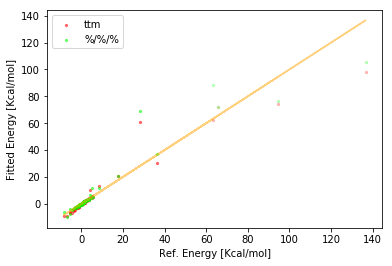

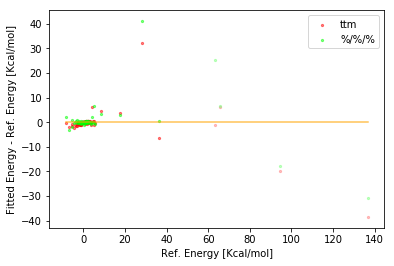

In [20]:
%matplotlib inline
potential_fitting.fitting.fit_visualizer.make_2b_graphs("ttm/eval-2b-ttm", "ttm/ttm-params.txt", "fit/eval-2b", "fitted.nc", database, "H2O", "NO3-", "%", "%", "%", "test")